# N2states Hidden Markov Model with Gaussian Emissions Categorical sampling in pymc3

In [1]:
import os
import sys
import time

In [2]:
import numpy as np
import scipy as sci
import pandas as pd
import seaborn as sns
from scipy import optimize
import matplotlib.pyplot as plt

In [3]:
import theano
import theano.tensor as tt
import theano.tensor.slinalg as sla
import theano.tensor.nlinalg as nla

import pymc3 as pm

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [4]:
theano.config.exception_verbosity = 'high'
os.environ["MKL_THREADING_LAYER"]="GNU"

In [5]:
print('Running on numpy: v{}'.format(np.version.version))
print('Running on theano: v{}'.format(theano.version.version))
print('Running on PYMC3: v{}'.format(pm.__version__))

Running on numpy: v1.15.4
Running on theano: v1.0.4
Running on PYMC3: v3.6


In [6]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
from IPython.display import HTML

In [7]:
%pylab inline

plt.style.use('seaborn-talk')

Populating the interactive namespace from numpy and matplotlib


/opt/conda/envs/jhub/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['sci']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [8]:
cwd = os.getcwd()
cwd

'/home/meysam/Hidden-Markov-Models'

The transition matrix used to generate simulated data is:

P=[[0.9, 0.1], [0.3, 0.7]]



In [15]:
P_th=np.array([[0.9, 0.1], [0.3, 0.7]])
P_th

array([[0.9, 0.1],
       [0.3, 0.7]])

In [16]:
data_states = np.loadtxt('SimulatedN2states.txt')
measurement= np.loadtxt('SimulatedMeasurementN2states.txt')

In [17]:
# Two state model for simplicity.
N_states = 2

In [18]:
# Number of data points.
Nt=1000

In [19]:
a=np.arange(N_states)

In [21]:
def unconditionalProbability(Ptrans):
   """Compute the unconditional probability for the states of a
   Markov chain."""

   m = Ptrans.shape[0]

   P = np.column_stack((Ptrans, 1. - Ptrans.sum(axis=1)))

   I = np.eye(m)
   U = np.ones((m, m))
   u = np.ones(m)

   return np.linalg.solve((I - P + U).T, u)

In [22]:
# equilibrium probabilities
PU = unconditionalProbability(P_th[:,:-1])
print('unconditionalProbability:', PU)
print('sum of unconditionalProbability:', np.sum(PU))

unconditionalProbability: [0.75 0.25]
sum of unconditionalProbability: 1.0


In [23]:
Pt=P_th[:,:-1]
print(np.concatenate((Pt.T,[1. - Pt.sum(axis=1)])).T)

[[0.9 0.1]
 [0.3 0.7]]


In [24]:
"""
Pt = tt.dmatrix('Pt')
P = tt.column_stack((Pt, 1. - Pt.sum(axis=1)))
m = Pt.shape[0]
PA = tt.slinalg.Solve((tt.eye(m) - P + tt.ones(m,m)).T, tt.ones(m))
equilibrium_probability = theano.function(Pt,PA)
"""

"\nPt = tt.dmatrix('Pt')\nP = tt.column_stack((Pt, 1. - Pt.sum(axis=1)))\nm = Pt.shape[0]\nPA = tt.slinalg.Solve((tt.eye(m) - P + tt.ones(m,m)).T, tt.ones(m))\nequilibrium_probability = theano.function(Pt,PA)\n"

In [25]:

# # create a set of states
# firstpoint = np.random.choice(2, 1, p=PU)
# print(firstpoint)

# data_states = [firstpoint[0]]
# for i in range(1,Nt):
#     data_states = np.concatenate((data_states,np.random.choice(2,1,p=P_th[data_states[-1]])))

In [26]:
data_states.shape

(1000,)

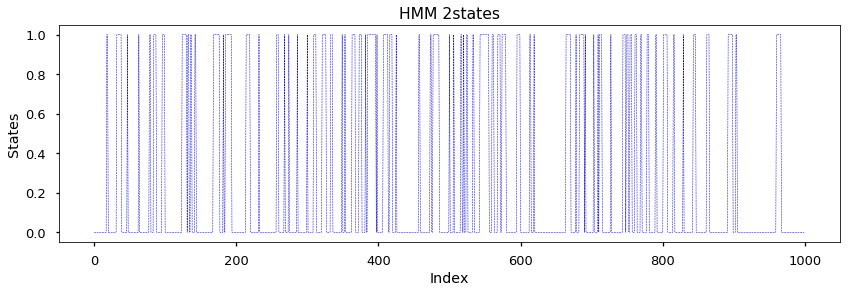

In [27]:
plt.figure(figsize=(14, 4))
plt.plot(data_states, '--', color='mediumblue', linewidth=.5)
plt.xlabel('Index'); 
plt.ylabel('States'); 
plt.title('HMM 2states')
plt.savefig(os.path.join(cwd+"/Figs","SimulatedDatastates_N2states.png"))
plt.show()

In [28]:
# measurement = data_states*1.0 + 0.1*np.random.randn(Nt)

In [29]:
#measurement.shape

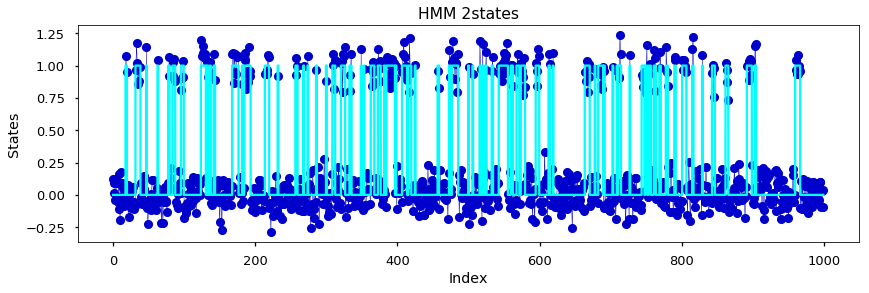

In [30]:
plt.figure(figsize=(14, 4))
plt.plot(measurement[:Nt], '-o', color='mediumblue', linewidth=.5)
plt.plot(data_states[:Nt], drawstyle='steps-mid', color='cyan')
plt.xlabel('Index'); 
plt.ylabel('States'); 
plt.title('HMM 2states')
plt.savefig(os.path.join(cwd+"/Figs","SimulatedMeasurement_N2states.png"))
plt.show()

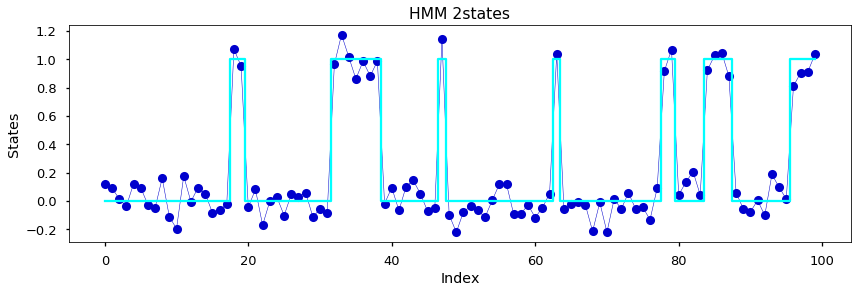

In [31]:
plt.figure(figsize=(14, 4))
plt.plot(measurement[:100], '-o', color='mediumblue', linewidth=.5)
plt.plot(data_states[:100], drawstyle='steps-mid', color='cyan')
plt.xlabel('Index'); 
plt.ylabel('States'); 
plt.title('HMM 2states')
plt.savefig(os.path.join(cwd+"/Figs","SimulatedMeasurement_N2states_zoom.png"))
plt.show()

In [32]:
#np.savetxt('SimulatedN2states.txt', data_states)
#np.savetxt('SimulatedMeasurementN2states.txt', measurement)

In [33]:
class HMMStatesN(pm.Categorical):
    """
    Hidden Markov Model States
    Parameters
    ----------
    P : tensor
        transition probability
        shape = (N_states,N_states)
        
    PA : tensor
         equilibrium probabilities
         shape = (N_states)
    
    """

    def __init__(self, PA=None, P=None, N_states=2,
                 *args, **kwargs):
        super(pm.Categorical, self).__init__(*args, **kwargs)
        self.P = P
        self.PA = PA
        self.k = N_states
        self.mode = tt.cast(0,dtype='int64')

    def logp(self, x):
        
        P = self.P
        PA = self.PA
        
        PS = P[x[:-1]]       
        x_i = x[1:]
        
        ou_like = pm.Categorical.dist(PS).logp(x_i)    
        return pm.Categorical.dist(PA).logp(x[0]) + tt.sum(ou_like)

    

In [34]:
class HMMGaussianEmissionsN(pm.Continuous):
    """
    Hidden Markov Model Gaussian Emissions
    Parameters
    ----------
    A : tensor
        prior for Gaussian emission mu
        shape = (2,N_states)
        
    S : tensor
        prior for Gaussian emission width
        shape = (2,N_states)
    
    states : tensor
         equilibrium probabilities
         shape = (N_states)
    
    """

    def __init__(self, A=None, S=None, states=None,
                 *args, **kwargs):
        super(HMMGaussianEmissionsN, self).__init__(*args, **kwargs)
        self.A = A
        self.S = S
        self.states = states
        self.mean = 0.

    def logp(self, x):
        A = self.A
        S = self.S
        states = self.states
        
        AS = A[states]        
        SS = S[states]
        
        ou_like = pm.Normal.dist(mu=AS,sd=SS).logp(x)
        return tt.sum(ou_like)

In [35]:
# Two state model for simplicity.
N_states = 2

In [36]:
# Transition probability stochastic
theta = np.ones((N_states,N_states)) + 1.

In [37]:
theta

array([[2., 2.],
       [2., 2.]])

In [38]:
# Prior

mu=np.array([0.0, 1.0])
cov=np.array([[1.0, 0.], [0., 1.]])


alphaA = np.ones(N_states)*2.1
betaA = np.ones(N_states)*1.1
alphaS = np.ones(N_states)*2.1
betaS = np.ones(N_states)*1.1

#alphaS = np.ones(N_states)*11.0
#betaS = np.ones(N_states)*1.

### Nuts and BinaryGibbsMetropolis Sampling

In [39]:
basic_model = pm.Model()

with basic_model:
    
    P = pm.Dirichlet('P', a=np.ones((N_states,N_states)), shape=(N_states,N_states))
    A = pm.MvNormal('A', mu, cov, shape=N_states)
    S = pm.InverseGamma('S', alpha=alphaS, beta=betaS, shape=N_states)
    
    AA = tt.dmatrix('AA')
        
    AA = tt.eye(N_states) - P + tt.ones(shape=(N_states,N_states))
    
    PA = pm.Deterministic('PA',sla.solve(AA.T,tt.ones(shape=(N_states))))
    
    states = HMMStatesN('states',PA=PA, P=P, N_states=N_states, shape=Nt)

    emission = HMMGaussianEmissionsN('emission', 
                                      A=A, 
                                      S=S, 
                                      states=states,
                                      observed=measurement)
    

/home/meysam/.local/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/meysam/.local/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


In [42]:
from pymc3.backends import SQLite , Text

In [43]:
NUTS_KWARGS={'tarhet_accept':0.99, 'max_treedepth': 10.}

In [44]:
with basic_model:
    db=pm.backends.Text('trace_nuts')
    trace_nuts = pm.sample(draws=2000, tune=10000, nuts_kwarg=NUTS_KWARGS, trace_nuts=db, chains=4)

/home/meysam/.local/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [S, A, P]
>BinaryGibbsMetropolis: [states]
Sampling 4 chains:   0%|          | 0/48000 [00:00<?, ?draws/s]/home/meysam/.local/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/meysam/.local/lib/python3.7/site-

In [45]:
filename='data_output_HMM_N2states_InferringEmission_Nuts'
if filename in os.listdir(cwd):
    print('Directory Exists')
if not os.path.exists(os.path.join(cwd, filename)):
    try:
        os.mkdir(os.path.join(cwd, filename))
    except OSError as exception:
            if exception.errno !=errno.EEXIST:
                raise

In [46]:
directory_nuts=os.path.join(cwd, str(filename))
directory_nuts

'/home/meysam/Hidden-Markov-Models/data_output_HMM_N2states_InferringEmission_Nuts'

In [47]:
pm.backends.text.dump(directory_nuts, trace_nuts, chains=None)

In [48]:
with basic_model:
     trace_nuts=pm.backends.text.load(directory_nuts)

In [49]:
print(trace_nuts.varnames)

['P_stickbreaking__', 'A', 'S_log__', 'states', 'P', 'S', 'PA']


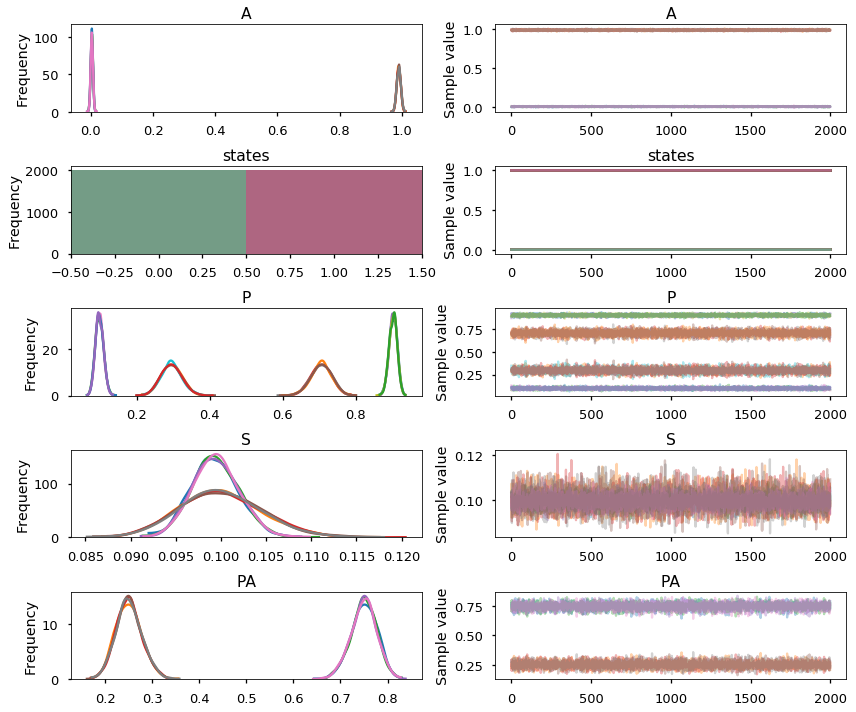

In [50]:
pm.traceplot(trace_nuts)
plt.savefig(os.path.join(cwd+"/Figs","EastimatedParams_HMM_N2states_InferringEmission_Nuts.png"))
plt.show()

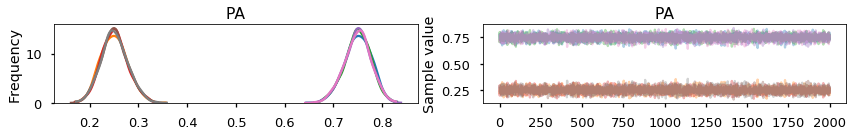

In [51]:
pm.traceplot(trace_nuts, varnames=['PA']);

/home/meysam/.local/lib/python3.7/site-packages/pymc3/plots/pairplot.py:148: UserWarning: No divergences were found.
  warnings.warn('No divergences were found.')


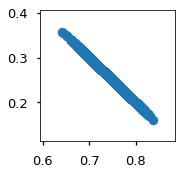

In [52]:
pm.pairplot(trace_nuts, varnames=['PA', 'P'], divergences=True);

In [53]:
trace_nuts['states'].shape

(8000, 1000)

In [54]:
A_est=np.asarray(trace_nuts.get_values('A', burn=0, combine=True))
P_est=np.asarray(trace_nuts.get_values('P', burn=0, combine=True))
S_est=np.asarray(trace_nuts.get_values('S', burn=0, combine=True))
PA_est=np.asarray(trace_nuts.get_values('PA', burn=0, combine=True))

In [55]:
A_est.shape

(8000, 2)

In [56]:
A_mean=np.mean(A_est, axis=0)
P_mean=np.mean(P_est, axis=0)
S_mean=np.mean(S_est, axis=0)
PA_mean=np.mean(PA_est, axis=0)

In [57]:
A_mean , P_mean, S_mean, PA_mean

(array([0.00286066, 0.9899859 ]), array([[0.90178409, 0.09821591],
        [0.29500081, 0.70499919]]), array([0.099372  , 0.09993972]), array([0.74952246, 0.25047754]))

In [58]:
P_th=np.array([[0.9, 0.1], [0.3, 0.7]])

In [59]:
sum(np.sqrt((P_th-P_mean)**2))

0.01356656788766708

In [60]:
trace_nuts['states'].shape

(8000, 1000)

In [61]:
sample_avg=np.average(trace_nuts['states'][0:],axis=0)

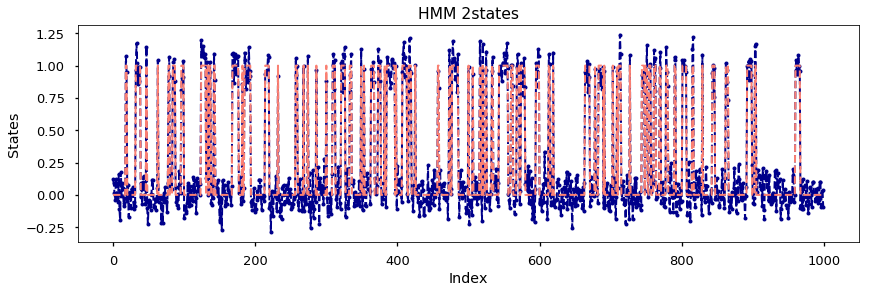

In [62]:
plt.figure(figsize=(14, 4))
plt.plot(measurement,color='darkblue', marker='o', linestyle='dashed',linewidth=2, markersize=4)
plt.plot(sample_avg, color='salmon', marker='o', linestyle='dashed',linewidth=2, markersize=.1)
plt.xlabel('Index'); 
plt.ylabel('States'); 
plt.title('HMM 2states')
plt.savefig(os.path.join(cwd+"/Figs","FittedMeasurement_HMM_N2states_InferringEmission_Nuts.png"))
plt.show()

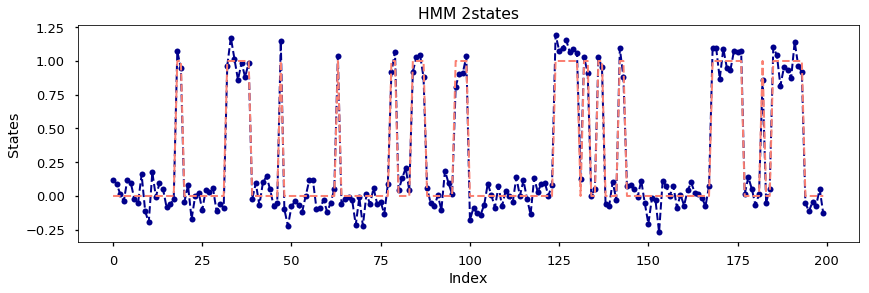

In [63]:
plt.figure(figsize=(14, 4))
plt.plot(measurement[0:200],color='darkblue', marker='o', linestyle='dashed',linewidth=2, markersize=6)
plt.plot(sample_avg[0:200], color='salmon', marker='o', linestyle='dashed',linewidth=2, markersize=.1)
plt.xlabel('Index'); 
plt.ylabel('States'); 
plt.title('HMM 2states')
plt.savefig(os.path.join(cwd+"/Figs","FittedMeasurement_HMM_N2states_InferringEmission_Nuts_zoom.png"))
plt.show()

In [64]:
#generate trace from posterior
ppc_trace = pm.sample_posterior_predictive(trace_nuts, samples=200, model=basic_model)

100%|██████████| 200/200 [00:08<00:00, 25.69it/s]


In [65]:
for key,val in ppc_trace.items():
    print (key, "=>", val)
    print (val.shape)

emission => [[ 0.12113637  0.08952768  0.01541167 ...  0.03150619  0.03453782
  -0.09323931]
 [ 0.12113637  0.08952768  0.01541167 ...  0.03150619  0.03453782
  -0.09323931]
 [ 0.12113637  0.08952768  0.01541167 ...  0.03150619  0.03453782
  -0.09323931]
 ...
 [ 0.12113637  0.08952768  0.01541167 ...  0.03150619  0.03453782
  -0.09323931]
 [ 0.12113637  0.08952768  0.01541167 ...  0.03150619  0.03453782
  -0.09323931]
 [ 0.12113637  0.08952768  0.01541167 ...  0.03150619  0.03453782
  -0.09323931]]
(200, 1000)


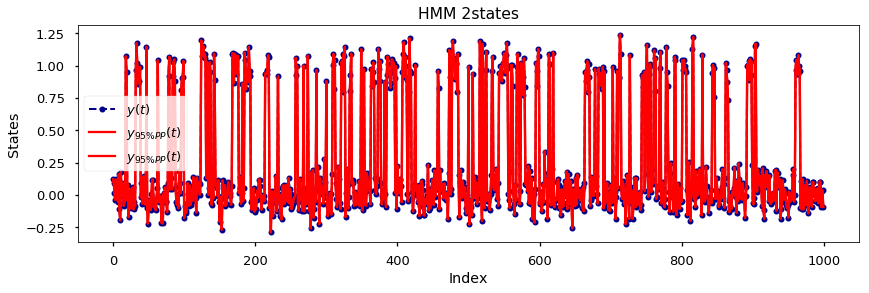

In [67]:
plt.figure(figsize=(14, 4))
plt.plot(measurement,color='darkblue', marker='o', linestyle='dashed',linewidth=2, markersize=6, label=r'$y(t)$')
plt.plot(percentile(ppc_trace['emission'], [2.5, 97.5], axis=0).T, 'r', label=r'$y_{95\% PP}(t)$')
plt.legend()
plt.xlabel('Index'); 
plt.ylabel('States'); 
plt.title('HMM 2states')
plt.savefig(os.path.join(cwd+"/Figs","PPCFittedMeasurement_HMM_N2states_InferringEmission_Nuts.png"))
plt.show()

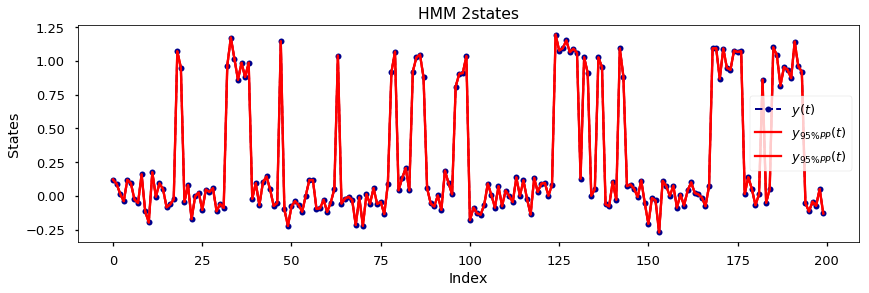

In [68]:
plt.figure(figsize=(14, 4))
plt.plot(measurement[0:200],color='darkblue', marker='o', linestyle='dashed',linewidth=2, markersize=6, label=r'$y(t)$')
plt.plot(percentile(ppc_trace['emission'], [2.5, 97.5], axis=0).T[0:200], 'r', label=r'$y_{95\% PP}(t)$')
plt.legend()
plt.xlabel('Index'); 
plt.ylabel('States'); 
plt.title('HMM 2states')
plt.savefig(os.path.join(cwd+"/Figs","PPCFittedMeasurement_HMM_N2states_InferringEmission_Nuts_zoom.png"))
plt.show()

In [69]:
trace_nuts.stat_names

set()

In [70]:
summary_nuts=pm.summary(trace_nuts).round(2)

In [71]:
summary_nuts[summary_nuts['Rhat']> 1.0]

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat


In [72]:
#trace_nuts_df = pm.trace_to_dataframe(trace_nuts)
#print(trace_nuts_df.describe().drop('count').T)

In [73]:
#from pandas.plotting import scatter_matrix
#scatter_matrix(trace_nuts_df, figsize=(12,12));

###  Metropolis and CategoricalGibbsMetropolis Sampling

In [74]:
basic_model2 = pm.Model()

with basic_model2:
    
    P = pm.Dirichlet('P', a=np.ones((N_states,N_states)), shape=(N_states,N_states))
    A = pm.MvNormal('A', mu, cov, shape=N_states)
    S = pm.InverseGamma('S', alpha=alphaS, beta=betaS, shape=N_states)
    
    AA = tt.dmatrix('AA')
        
    AA = tt.eye(N_states) - P + tt.ones(shape=(N_states,N_states))
    
    PA = pm.Deterministic('PA',sla.solve(AA.T,tt.ones(shape=(N_states))))
    
    states = HMMStatesN('states',PA=PA, P=P, N_states=N_states, shape=Nt)

    emission = HMMGaussianEmissionsN('emission', 
                                      A=A, 
                                      S=S, 
                                      states=states,
                                      observed=measurement)
     
    step1 = pm.Metropolis(vars=[P,A,S,PA,emission])
    step2 = pm.CategoricalGibbsMetropolis(vars=[states])
    

/home/meysam/.local/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


In [75]:
with basic_model2:
    start = pm.find_MAP(fmin=optimize.fmin_powell)
    db_categorical=pm.backends.Text('trace_categorical')
    trace_categorical = pm.sample(draws=2000, tune=10000, step=[step1, step2],  start=start,  trace_categorical=db_categorical, chains=4)

/home/meysam/.local/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
/home/meysam/.local/lib/python3.7/site-packages/pymc3/tuning/starting.py:102: UserWarning: In future versions, set the optimization algorithm with a string. For example, use `method="L-BFGS-B"` instead of `fmin=sp.optimize.fmin_l_bfgs_b"`.
  warnings.warn('In future versions, set the optimization algorithm with a string. '
  0%|          | 0/5000 [00:00<?, ?it/s]/home/meysam/.local/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this wi

Optimization terminated successfully.
         Current function value: 594.914612
         Iterations: 3
         Function evaluations: 345


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [P]
>>Metropolis: [S]
>>Metropolis: [A]
>CategoricalGibbsMetropolis: [states]
Sampling 4 chains:  12%|█▏        | 5653/48000 [13:45<1:24:45,  8.33draws/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Sampling 4 chains:  53%|█████▎    | 25340/48000 [49:40<42:39,  8.85draws/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Sampling 4 chains:  96%|█████████▌| 4

In [76]:
filename='data_output_HMM_N2states_InferringEmission_Categorical'
if filename in os.listdir(cwd):
    print('Directory Exists')
if not os.path.exists(os.path.join(cwd, filename)):
    try:
        os.mkdir(os.path.join(cwd, filename))
    except OSError as exception:
            if exception.errno !=errno.EEXIST:
                raise

In [77]:
directory_categorical=os.path.join(cwd, str(filename))
directory_categorical

'/home/meysam/Hidden-Markov-Models/data_output_HMM_N2states_InferringEmission_Categorical'

In [78]:
pm.backends.text.dump(directory_categorical, trace_categorical, chains=None)

In [79]:
with basic_model2:
     trace_categorical=pm.backends.text.load(directory_categorical)

In [80]:
print(trace_categorical.varnames)

['P_stickbreaking__', 'A', 'S_log__', 'states', 'P', 'S', 'PA']


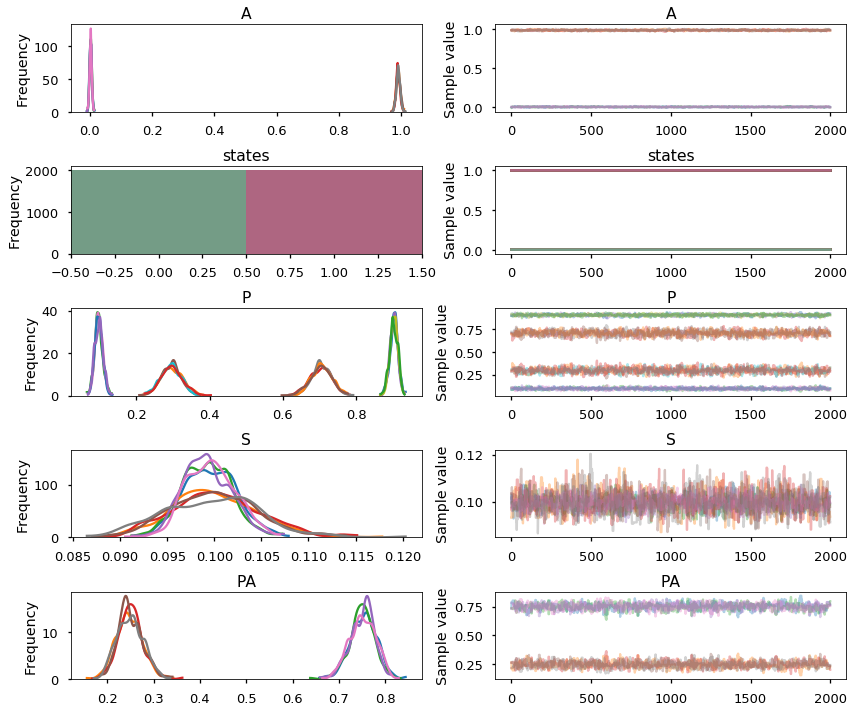

In [81]:
pm.traceplot(trace_categorical)
plt.savefig(os.path.join(cwd+"/Figs","EastimatedParams_HMM_N2states_InferringEmission_Categorical.png"))
plt.show()



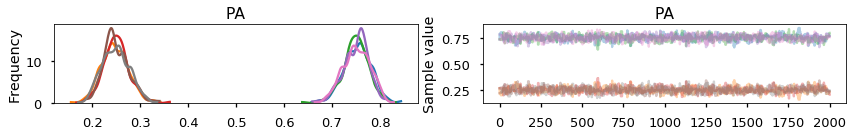

In [82]:
pm.traceplot(trace_categorical, varnames=['PA']);

/home/meysam/.local/lib/python3.7/site-packages/pymc3/plots/pairplot.py:148: UserWarning: No divergences were found.
  warnings.warn('No divergences were found.')


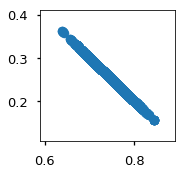

In [83]:
pm.pairplot(trace_categorical, varnames=['PA', 'P'], divergences=True);

In [84]:
trace_categorical['states'].shape

(8000, 1000)

In [85]:
A_est=np.asarray(trace_categorical.get_values('A', burn=0, combine=True))
P_est=np.asarray(trace_categorical.get_values('P', burn=0, combine=True))
S_est=np.asarray(trace_categorical.get_values('S', burn=0, combine=True))
PA_est=np.asarray(trace_categorical.get_values('PA', burn=0, combine=True))

In [86]:
A_est.shape

(8000, 2)

In [87]:
A_mean=np.mean(A_est, axis=0)
P_mean=np.mean(P_est, axis=0)
S_mean=np.mean(S_est, axis=0)
PA_mean=np.mean(PA_est, axis=0)

In [88]:
A_mean , P_mean, S_mean, PA_mean

(array([0.00301336, 0.99032927]), array([[0.9021339 , 0.0978661 ],
        [0.29575599, 0.70424401]]), array([0.0993738 , 0.09991815]), array([0.75065819, 0.24934181]))

In [89]:
P_th=np.array([[0.9, 0.1], [0.3, 0.7]])

In [90]:
sum(np.sqrt((P_th-P_mean)**2))

0.012755815601740439

In [91]:
trace_categorical['states'].shape

(8000, 1000)

In [92]:
sample_avg=np.average(trace_categorical['states'][0:],axis=0)

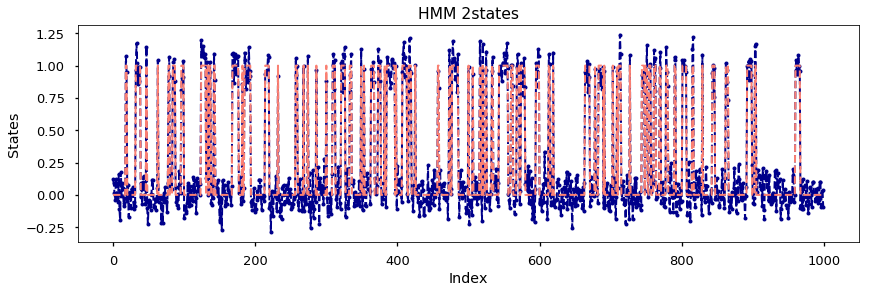

In [93]:
plt.figure(figsize=(14, 4))
plt.plot(measurement,color='darkblue', marker='o', linestyle='dashed',linewidth=2, markersize=4)
plt.plot(sample_avg, color='salmon', marker='o', linestyle='dashed',linewidth=2, markersize=.1)
plt.xlabel('Index'); 
plt.ylabel('States'); 
plt.title('HMM 2states')
plt.savefig(os.path.join(cwd+"/Figs","FittedMeasurement_HMM_N2states_InferringEmission_Categorical.png"))
plt.show()

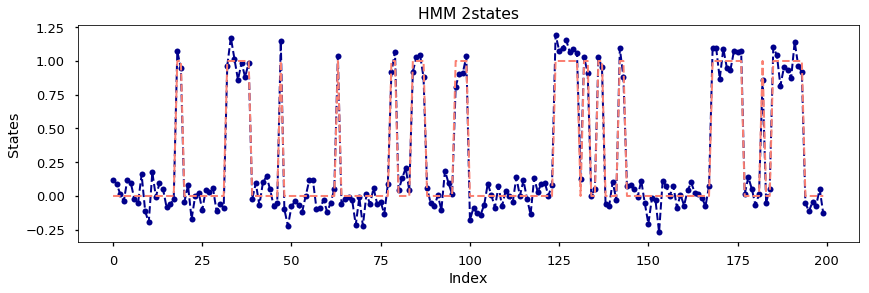

In [94]:
plt.figure(figsize=(14, 4))
plt.plot(measurement[0:200],color='darkblue', marker='o', linestyle='dashed',linewidth=2, markersize=6)
plt.plot(sample_avg[0:200], color='salmon', marker='o', linestyle='dashed',linewidth=2, markersize=.1)
plt.xlabel('Index'); 
plt.ylabel('States'); 
plt.title('HMM 2states')
plt.savefig(os.path.join(cwd+"/Figs","FittedMeasurement_HMM_N2states_InferringEmission_Categorical_zoom.png"))
plt.show()

In [95]:
#generate trace from posterior
ppc_trace = pm.sample_posterior_predictive(trace_categorical, samples=200, model=basic_model2)

100%|██████████| 200/200 [00:08<00:00, 24.52it/s]


In [96]:
for key,val in ppc_trace.items():
    print (key, "=>", val)
    print (val.shape)

emission => [[ 0.12113637  0.08952768  0.01541167 ...  0.03150619  0.03453782
  -0.09323931]
 [ 0.12113637  0.08952768  0.01541167 ...  0.03150619  0.03453782
  -0.09323931]
 [ 0.12113637  0.08952768  0.01541167 ...  0.03150619  0.03453782
  -0.09323931]
 ...
 [ 0.12113637  0.08952768  0.01541167 ...  0.03150619  0.03453782
  -0.09323931]
 [ 0.12113637  0.08952768  0.01541167 ...  0.03150619  0.03453782
  -0.09323931]
 [ 0.12113637  0.08952768  0.01541167 ...  0.03150619  0.03453782
  -0.09323931]]
(200, 1000)


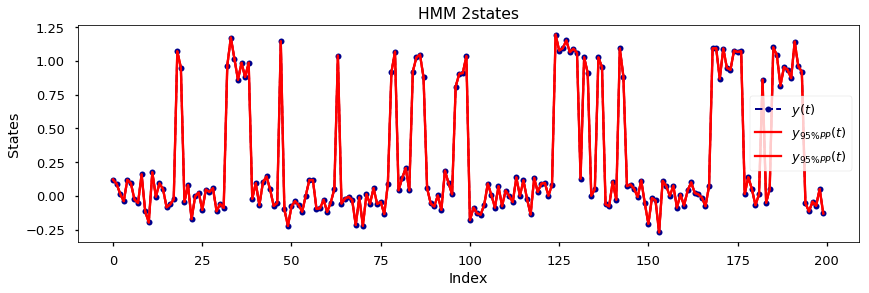

In [97]:
plt.figure(figsize=(14, 4))
plt.plot(measurement[0:200],color='darkblue', marker='o', linestyle='dashed',linewidth=2, markersize=6, label=r'$y(t)$')
plt.plot(percentile(ppc_trace['emission'], [2.5, 97.5], axis=0).T[0:200], 'r', label=r'$y_{95\% PP}(t)$')
plt.legend()
plt.xlabel('Index'); 
plt.ylabel('States'); 
plt.title('HMM 2states')
plt.savefig(os.path.join(cwd+"/Figs","PPCFittedMeasurement_HMM_N2states_InferringEmission_Ccategorical.png"))
plt.show()

In [98]:
summary_categorical=pm.summary(trace_categorical).round(2)

In [99]:
summary_categorical[summary_categorical['Rhat']> 1.0]

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
